---
syncID: 464ac0a0b63e4e679c6f6f36ca5130c7
title: "Exploring NEON AOP remote sensing and GBIF occurrence data in Google Earth Engine Python (geemap) to assess the impacts of a wildfire"
description: "Explore AOP reflectance along with "
dateCreated: 2025-04-24
authors: Kit Lewers
contributors: Chandra Earl, Kelsey Yule, Bridget Hass
estimatedTime: 1 hour
packagesLibraries: earthengine-api, geemap, geopandas, pygbif, shapely, seaborn
topics: biorepository, beetles, remote-sensing
languagesTool: Python, Google Earth Engine
dataProducts: DP3.30006.001, DP3.30006.002
code1: https://github.com/NEONScience/NEON-Data-Skills/edit/main/tutorials/Other/GEE_Python/04_aop_gbif_gee_py/Intro_AOP_GBIF_GEE_Python.ipynb
tutorialSeries: 
urlTitle: aop-gbif-gee-py
---

## Exploring NEON AOP (Airborne Operations Platform) and Biorepository Data Together

In this tutorial, we will use NEON airborne hyperspectral data collected in 2016 and 2017 at the NEON <a href="https://www.neonscience.org/field-sites/grsm" target="_blank">GRSM (Great Smokey Mountains)</a> site to map the area affected by the <a href="https://www.neonscience.org/impact/observatory-blog/neons-great-smoky-mountains-data-will-capture-tennessee-fire-impacts-local" target="_blank">Chimney Tops Fire</a>. We will use the GEE (Google Earth Engine) Python API to explore the burn scar using the NBR (Normalized Burn Ratio) to set a threshold to identify burned and unburned areas. We will then use the <a href="https://pygbif.readthedocs.io/" target="_blank">pygbif</a> (Python Global Biodiversity Information Facility) library to pull records from the NEON Biorepository to see if and/or how Carabid beetle communities in the domain were impacted by the fires.

This workflow illustrates how NEON’s open data products—airborne remote sensing and biodiversity occurrence records—can be integrated to explore species-level responses to spatially explicit disturbances. By overlaying mapped burn areas with species occurrence data, we can assess whether wildfire affected the composition or distribution of ground beetle communities. Beyond this specific case, the approach highlights the potential of combining ecological and remote sensing data to investigate landscape-scale disturbance impacts, recovery dynamics, and long-term changes in community structure.

### Background
#### NEON Airborne Observation Platform and Google Earth Engine
 <a href="https://www.neonscience.org/data-collection/airborne-remote-sensing" target="_blank">Airborne remote sensing</a> surveys are conducted over NEON field sites during peak greenness and provide quantitative information on land cover and changes to ecological structure and chemistry. The surveys are supported by the NEON Airborne Observation Platform (AOP), which collects regional-scale landscape information at the NEON field sites. The AOP maps areas where NEON's observational and instrumented sampling is occurring and allows relationships to be drawn between NEON's detailed in-situ observations to the broader environmental and ecological conditions. AOP data are available on the NEON Data Portal, and can also be downloaded programmatically using the <a href="https://pypi.org/project/neonutilities/" target="_blank">Python neonutilities</a> or <a href="https://cran.r-project.org/web/packages/neonUtilities/index.html" target="_blank">R neonUtilities</a> packages, and a subset of the data are also made available on Google Earth Engine Publisher datasets. This tutorial demonstrates working with full-site hyperspectral data that are available on GEE, using the Python API.

#### Ground Beetles and the NEON Biorepository
Ground beetles (Coleoptera: Carabidae) are widely recognized as effective bioindicators due to their sensitivity to environmental changes, particularly in relation to environmental changes, vegetation structure, and habitat disturbance. They are highly diverse, relatively easy to sample, and their community composition often reflect changes in local and landscape-scale conditions. Following natural or anthropogenic disturbances, beetle communities typically shift — favoring small-bodied, mobile, and ecologically flexible species in the early stages of recovery. As the habitat stabilizes over time, habitat specialists become more prevalent. Tracking these changes in species composition and abundance offers insight into ecosystem processes and can help assess the trajectory of recovery or the effectiveness of restoration efforts.

At NEON field sites, Carabid beetles are captured biweekly during the growing season using pitfall traps. The trap contents are then sorted, with Carabids separated and identified to the species level. Select specimens are preserved as individual pinned reference vouchers, while the rest are stored in 95% ethanol for long-term archiving. Non-Carabid material from the traps is also retained for future use. All specimens are ultimately stored in the <a href="https://biorepo.neonscience.org/portal/" target="_blank">NEON Biorepository</a>, housed at Arizona State University, for long-term storage and curation. The NEON Biorepository makes these datasets available via <a href="https://www.gbif.org/" target="_blank">GBIF</a>, a global platform that aggregates biodiversity data from thousands of sources.


<div id="ds-objectives" markdown="1">

### Objectives
After completing this tutorial, you will be able to use Python to:

* Read in multiple visits and visualize AOP reflectance datasets
* Calculate NBR (Normalized Burn Ratio) from reflectance data
* Read in GBIF Occurrence Records using the pygbif package
* Visualize AOP Imagery and GBIF records together
* Conduct exploratory analysis to see if and how the fire impacted Carabid species composition

### Requirements

To follow along with this code, you will need to:
1. Sign up for a non-commercial Google Earth Engine account here https://code.earthengine.google.com/register.
2. Install **Python 3.10+**
3. Install required Python packages
   
- `pip install earthengine-api --upgrade`
- `pip install geemap`
- `pip install pygbif`
- `pip install geopandas`
- `pip install shapely`
- `pip install seaborn`

### Additional Resources
- <a href="https://www.neonscience.org/resources/learning-hub/tutorials/aop-gee-py-intro" target="_blank">Intro to AOP Datasets in Google Earth Engine (GEE) using Python</a>
- <a href="https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api" target="_blank">Google Developers Intro to Python API</a>
- <a href="https://book.geemap.org/" target="_blank">`geemap` Text Book</a>
- <a href="https://www.youtube.com/@giswqs" target="_blank">`geemap` YouTube Channel</a>

</div>



## Part 1: Reading in and Visualizing AOP Imagery and GBIF Occurrence Records

Let's get started! First we'll read in and visualize the AOP surface bidirectional reflectance data at the Great Smokey Mountains site, using GEE in Python.

#### Import required packages

In [1]:
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pygbif import occurrences as gbif_occ
import seaborn as sns
from shapely.geometry import Polygon
from shapely import wkt

# GEE packages
import ee
import geemap

To use the `ee` package, you will first need to Authenticate and Initialize. When you initialize you can specify your Google Cloud Platform (GCP) project name, or otherwise you will need to specify it as part of the intialization process.

In [2]:
ee.Authenticate()
ee.Initialize()
# optionally specify the project name
# ee.Initialize(`gcp-project-name`)

#### Find Available NEON Hyperspectral Imagery on GEE

This next chunk of code shows how to find the available data on GEE at the Great Smokey Mountain (GRSM) site. Note that NEON data availability on GEE may not directly match availabilty on the NEON Data Portal, as of 2025. Additional data can be added to GEE upon request by emailing listaopgee@battelleecology.org. 

In [3]:
# Define an area of interest, for the imagery, I will simply be using a centroid because I want all
# the imagery from GRSM domain. You can using a bounding box, shapefiles, etc. if you want a more granular
# control of the geographic area

site_center = ee.Geometry.Point([-83.5, 35.7])

# Load Hyperspectral AOP Image Collection
sdr_col = ee.ImageCollection('projects/neon-prod-earthengine/assets/HSI_REFL/001')

# Retrieve all available image IDs to make a list if you want to see everything, but also to cross 
# reference years you may want
image_ids = sdr_col.aggregate_array("system:index").getInfo()
print("Available AOP Image IDs:", image_ids)

# Define a function that allows you to look through multiple years and domains of image collections
def filter_aop_images(years, domains):
    """
    Filters the AOP image collection based on a list of years and domains.
    
    Parameters:
        years (list): List of years (e.g., ["2016", "2017"]).
        domains (list): List of 4-letter site codes (e.g., ["GRSM", "HARV"]).
    
    Returns:
        Dictionary with (year, domain) as key and list of matching image IDs.
    """
    filtered_results = {}

    for year in years:
        for domain in domains:
            matching_ids = [img_id for img_id in image_ids if year in img_id and domain in img_id]
            if matching_ids:
                filtered_results[(year, domain)] = matching_ids

    return filtered_results

# Define years and domains that you want to look at (NOTE: this code can be used to look at 
# multiple years and domains)
years_input = ["2016", "2017"]  # Add multiple years here
domains_input = ["GRSM"]  # Add multiple domains here

# Get image filtered by year and domain
filtered_images = filter_aop_images(years_input, domains_input)

# NEON does not fly every single domain every year so there may be years where imagery is unavailable
# I like to have a conditional statement so I can easily check if there are no images available, but 
# also print a list in case only some years are available
if not filtered_images:
    print(f"No AOP images found for the selected years and domains.")
else:
    print(f"AOP images matching search criteria: {filtered_images}")

Available AOP Image IDs: ['2013_CPER_1', '2014_HARV_2', '2014_JERC_1', '2015_MLBS_1', '2015_TALL_1', '2016_CLBJ_1', '2016_GRSM_2', '2016_HARV_3', '2016_JERC_2', '2016_SERC_1', '2016_TALL_2', '2017_CLBJ_2', '2017_CPER_3', '2017_GRSM_3', '2017_HARV_4', '2017_JERC_3', '2017_MLBS_2', '2017_OAES_2', '2017_SERC_3', '2017_SRER_1', '2017_TALL_3', '2018_GUAN_1', '2018_HARV_5', '2018_JERC_4', '2018_MCRA_1', '2018_MLBS_3', '2018_OAES_3', '2018_SRER_2', '2018_TALL_4', '2019_CLBJ_4', '2019_HARV_6', '2019_HEAL_3', '2019_JERC_5', '2019_JORN_3', '2019_NIWO_3', '2019_OAES_4', '2019_SERC_4', '2019_SOAP_4', '2019_SRER_3', '2019_TALL_5', '2020_CPER_5', '2020_CPER_7', '2020_NIWO_4', '2020_RMNP_3', '2020_YELL_3', '2021_ABBY_4', '2021_BONA_4', '2021_CLBJ_5', '2021_CPER_8', '2021_HEAL_4', '2021_JERC_6', '2021_JORN_4', '2021_MCRA_2', '2021_OAES_5', '2021_OSBS_6', '2021_SERC_5', '2021_SJER_5', '2021_SOAP_5', '2021_SRER_4', '2021_TALL_6']
AOP images matching search criteria: {('2016', 'GRSM'): ['2016_GRSM_2'], (

#### Calculate NBR (Normalized Burn Ratio) and visualize for 2016 and 2017 imagery

The Normalized Burn Ratio is a standard index derived from multi or hyperspectral data to indicate burn severity. We will use the GEE `normalizedDifference` method to calculate NBR from the AOP hyperspectral data and visualize this in 2016 and 2017 to display the impact from the Chimney Tops Fire on the landscape.

In [4]:
# NBR Visualization Parameters
nbr_vis_params = {
    'min': -1, 'max': 1,
    'palette': ['white', 'yellow', 'red', 'black']  # typical burn severity color ramp
}

# Function to Compute NBR
def addNBRBands(image):
    nbr = image.normalizedDifference(['B097', 'B220']).rename('NBR')
    return image.addBands(nbr).set({'Sensor': 'AOP'})

# Create a geemap Map instance for NBR visualization
NBR_Map = geemap.Map()
NBR_Map.centerObject(site_center, 11)

# Loop through filtered images and compute NBR
for (year, domain), image_ids in filtered_images.items():
    for image_id in image_ids:
        # Retrieve the image by its system:index
        aop_image = sdr_col.filter(ee.Filter.eq("system:index", image_id)).first()

        # Compute NBR
        if aop_image:
            aop_nbr = addNBRBands(aop_image).select('NBR')
            print(f"NBR computed for AOP image: {image_id}")

            # Add layer with proper naming
            NBR_Map.addLayer(aop_nbr, nbr_vis_params, f'AOP NBR ({image_id})')

# Save the final interactive HTML map for NBR
html_nbr_filename = f"AOP_NBR_{'_'.join(years_input)}_{'_'.join(domains_input)}.html"
NBR_Map.to_html(filename=html_nbr_filename)

print(f"NBR visualization saved: {html_nbr_filename}")

NBR computed for AOP image: 2016_GRSM_2
NBR computed for AOP image: 2017_GRSM_3
NBR visualization saved: AOP_NBR_2016_2017_GRSM.html


You can open up the html to interactively view the 2016 and 2017 NBR images. You should see something like the following:

<table><tr>
<td> <img src="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/aop-gee-python/aop_gbif/GRSM_2016_NBR.png" width="600"> </td>
<td> <img src="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/aop-gee-python/aop_gbif/GRSM_2017_NBR.png" width="600"> </td>
</table>
<figcaption>Normalized Burn Ratio (NBR) at the NEON GRSM site before the Chimney Tops Fire (2016, left) and after the fire (2017, right).  
</figcaption>

#### Read in GBIF Occurrence Data

Primary biodiversity data, also known as occurrence data, consist of records documenting observations of specific species at particular locations and times. These records form the foundation for understanding species distributions, tracking biodiversity changes over time, and supporting ecological and conservation research.

To begin exploring these patterns, we'll read in the carabid beetle occurrence records using `gbif_occ` and create a geodataframe from those data.

In [5]:
# Specify GRSM centroid and bounding box parameters
latitude, longitude = 35.6118, -83.4895
bbox_size_deg = 0.09  # Approx. 10 km (~0.09 degrees)

# Create bounding box polygon
bounding_box_coords = [
    (longitude - bbox_size_deg, latitude - bbox_size_deg),  # Bottom-left
    (longitude + bbox_size_deg, latitude - bbox_size_deg),  # Bottom-right
    (longitude + bbox_size_deg, latitude + bbox_size_deg),  # Top-right
    (longitude - bbox_size_deg, latitude + bbox_size_deg),  # Top-left
    (longitude - bbox_size_deg, latitude - bbox_size_deg)   # Close polygon
]
bounding_polygon = Polygon(bounding_box_coords)
polygon_wkt = bounding_polygon.wkt

# Get carabid records
carabid_records = []
carabid_taxon_key = 3792  # <-- update with correct taxon key for Carabidae
for year in [2016, 2017]:
    occurrences = gbif_occ.search(
        taxonKey=carabid_taxon_key,
        geometry=polygon_wkt,
        year=year,
        hasCoordinate=True,
        limit=300
    )
    prefix = f"grsm.{year}".lower()
    for occ in occurrences.get("results", []):
        if "eventID" in occ and occ["eventID"].lower().startswith(prefix):
            try:
                lat = float(occ["decimalLatitude"])
                lon = float(occ["decimalLongitude"])
                carabid_records.append({
                    "species": occ.get("species", "Unknown"),
                    "latitude": lat,
                    "longitude": lon,
                    "year": year,
                    "eventID": occ.get("eventID")
                })
            except (KeyError, TypeError, ValueError):
                continue

# Convert carabid records to GeoDataFrame and export as GeoJSON and CSV
carabid_gdf = gpd.GeoDataFrame(
    carabid_records,
    geometry=gpd.points_from_xy(
        [r['longitude'] for r in carabid_records],
        [r['latitude'] for r in carabid_records]
    ),
    crs="EPSG:4326"
)

# Write the geodataframe to a geojson and csv file
carabid_gdf.to_file("gbif_carabids_grsm_2016_2017.geojson", driver="GeoJSON")
carabid_gdf.drop(columns='geometry').to_csv("gbif_carabids_grsm_2016_2017.csv", index=False)

INFO:Created 417 records


#### Visualize AOP Imagery and GBIF records together

This last cell combines the AOP NBR map along with the GBIF records, so you can see where those records occured.

In [6]:
# Load GBIF records from the GeoJSON file
gbif_geojson = "gbif_carabids_grsm_2016_2017.geojson"
carabid_gdf = gpd.read_file(gbif_geojson)

# Separate the GBIF records by year
carabid_2016 = carabid_gdf[carabid_gdf["year"] == 2016]
carabid_2017 = carabid_gdf[carabid_gdf["year"] == 2017]

# Add the GBIF points to the map as separate layers
NBR_Map.add_gdf(carabid_2016, layer_name="GBIF NEON Carabidae Trap Records 2016")
NBR_Map.add_gdf(carabid_2017, layer_name="GBIF NEON Carabidae Trap Records 2017")

# (Optional) Save the interactive NBR_map to an HTML file
output_html = "GRSM_GBIF_NBR_Map.html"
NBR_Map.to_html(filename=output_html)
print(f"Combined map saved as: {output_html}")

Combined map saved as: GRSM_GBIF_NBR_Map.html


Now if you open this new html, you should be able to see the Carabidae Trap Records:

<figure>
	<a href="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/aop-gee-python/aop_gbif/GRSM_NBR_Carabidae_Trap_Records.png">
	<img src="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/aop-gee-python/aop_gbif/GRSM_NBR_Carabidae_Trap_Records.png" alt="GRSM Trap Records" width="800">
    <figcaption>Great Smokey Mountain NBR overlaid with GBIF Carabidae Trap Records</figcaption></a>
</figure>

## Part 2: Additional Analysis - Impact of the Fire on GBIF Records

In this next section, we'll see if we can gain any insights as to if and how the fire impacted the beetle trap records.

This next chunk of code vectorizes the burn scar mask, which we can then use to assess differences in the GBIF occurrence data relative to burn percentages for a given location.

In [7]:
# --- STEP 1: Select pre-fire and post-fire images ---
# Assuming filtered_images is a dictionary with keys like ('2016', 'GRSM') and ('2017', 'GRSM')
# Here we simply choose the first image ID for each year.
pre_fire_img_id = filtered_images.get(('2016', 'GRSM'))[0]
post_fire_img_id = filtered_images.get(('2017', 'GRSM'))[0]

# Retrieve the images from the collection
pre_fire_image = sdr_col.filter(ee.Filter.eq("system:index", pre_fire_img_id)).first()
post_fire_image = sdr_col.filter(ee.Filter.eq("system:index", post_fire_img_id)).first()

# --- STEP 2: Compute NBR for each image using your function ---
pre_fire_nbr = addNBRBands(pre_fire_image).select('NBR')
post_fire_nbr = addNBRBands(post_fire_image).select('NBR')

# --- STEP 3: Calculate dNBR (difference NBR) ---
dnbr = pre_fire_nbr.subtract(post_fire_nbr).rename('dNBR')

# --- STEP 4: Apply a threshold to classify burned areas ---
# Example: mark pixels as burned if dNBR > 0.27 (indicative of moderate to high burn severity)
burn_threshold = 0.27  # This value may be adjusted based on local calibration or sensor characteristics.
burned_area_mask = dnbr.gt(burn_threshold)

# Optional: visualize burned vs unburned areas using a simple palette.
dnbr_viz_params = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'orange', 'red']
}

# --- STEP 5: Vectorize the Burn Scar Mask ---
# Define a region of interest (ROI) for vectorization.
# You might base this on an extent around your site_center; here we buffer the center by 5000m.
roi = site_center.buffer(5000)

# Convert the burned area mask into vectors (polygons)
burn_vectors = burned_area_mask.selfMask().reduceToVectors(
    geometry=roi,
    crs=post_fire_image.projection(), 
    scale=10,  # Adjust scale (pixel size) as appropriate for the data.
    geometryType='polygon',
    labelProperty='burned',
    reducer=ee.Reducer.countEvery()
)

# --- STEP 6: Visualize the dNBR, burned area, and vectorized burn scar on the map ---
# Create a geemap Map instance (if not already created)
NBR_Map = geemap.Map()
NBR_Map.centerObject(site_center, 11)

# Add dNBR layer
NBR_Map.addLayer(dnbr, dnbr_viz_params, 'dNBR (Pre-fire minus Post-fire)')

# Add burned area mask layer
NBR_Map.addLayer(burned_area_mask.selfMask(), {'palette': 'red'}, 'Burned Area Mask')

# Add burn scar vectors layer
NBR_Map.addLayer(burn_vectors, {}, 'Burn Scar Polygons')

# Optionally, save the interactive map
output_html = "GRSM_Burn_Scar_Map.html"
NBR_Map.to_html(filename=output_html)
print(f"Burn scar map saved as: {output_html}")

# --- Optional: Export the burn scar vectors as a shapefile ---
# If you wish to export the vector data from Earth Engine, use Export.table.toDrive
# Uncomment the code below to do this

# export_task = ee.batch.Export.table.toDrive(
#     collection=burn_vectors,
#     description='BurnScar_Shapefile_Export',
#     folder='EarthEngineExports',
#     fileFormat='SHP'
# )
# export_task.start()
# print("Export of burn scar shapefile initiated.")

Burn scar map saved as: GRSM_Burn_Scar_Map.html


If you open this next html, you can see the vectorized burn scar.

<figure>
	<a href="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/aop-gee-python/aop_gbif/GRSM_Burn_Scar_Map.png">
	<img src="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/aop-gee-python/aop_gbif/GRSM_Burn_Scar_Map.png" alt="GRSM Burn Scar" width="800">
    <figcaption>Great Smokey Mountains Chimney Tops Fire Burn Scar</figcaption></a>
</figure>

#### Compare GBIF presence / absence data from 2016 to 2017

Next, we will compare species presence data from GBIF for ground beetles collected before and after the fire, using 2016 (pre-fire) and 2017 (post-fire) records. By examining which species were detected in each year, we can infer absences and explore changes in community composition following the disturbance, shedding light on how the fire may have influenced beetle species richness.


presence data:
year                       2016  2017
species                              
Amphasia interstitialis       0     1
Anillinus langdoni            0     1
Aulacopodus brouni            1     0
Carabus goryi                 1     1
Cyclotrachelus freitagi       1     1
Cyclotrachelus sigillatus     1     1
Cylindera unipunctata         1     1
Dicaelus dilatatus            1     1
Dicaelus politus              0     1
Dicaelus teter                1     1
Galerita bicolor              1     0
Gastrellarius blanchardi      1     0
Notiophilus aeneus            0     1
Pasimachus punctulatus        1     1
Pterostichus acutipes         1     1
Pterostichus coracinus        1     0
Pterostichus moestus          1     0
Pterostichus stygicus         1     0
Pterostichus tristis          1     1
Scaphinotus andrewsii         1     0
Scaphinotus guyotii           1     0
Sphaeroderus bicarinatus      1     1
Sphaeroderus canadensis       1     0
Sphaeroderus stenostomus      1    

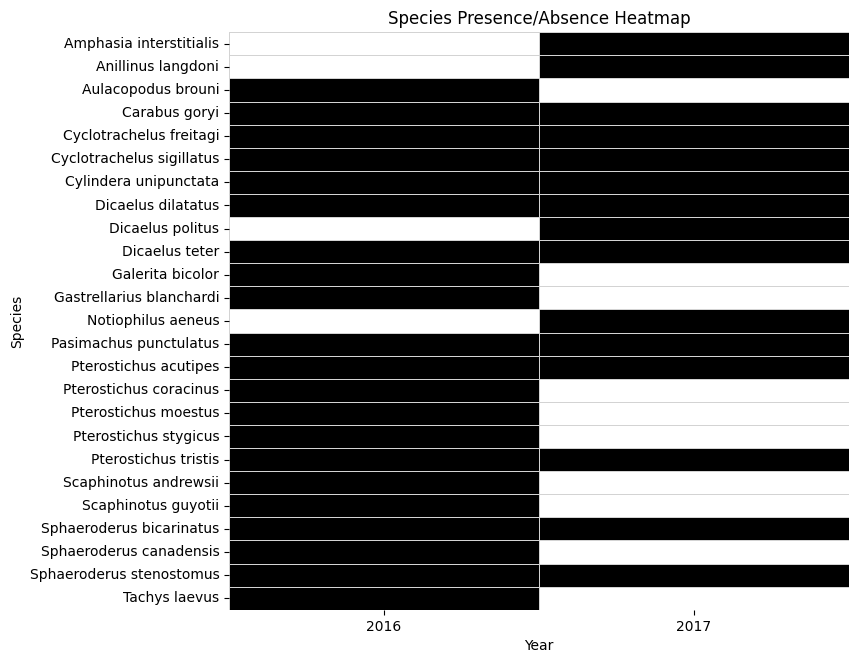

In [8]:
# Load the GBIF records
gbif_geojson = "gbif_carabids_grsm_2016_2017.geojson"
occ_gdf = gpd.read_file(gbif_geojson)

# Create a presence flag by dropping duplicate species–year pairs
presence_df = (
    occ_gdf[['species', 'year']]
    .drop_duplicates()           # keep one row per species/year
    .assign(presence=1)          # mark presence
)

# Pivot so each species is a row, columns are years, values are presence (1) or absence (0)
presence_pivot = (
    presence_df
    .pivot(index='species', columns='year', values='presence')
    .fillna(0)
    .astype(int)
)

# Display the presence data
print('presence data:')
print(presence_pivot)

# Plot a heatmap of the presence/absence data
plt.figure(figsize=(8, max(4, len(presence_pivot) * 0.3)))
sns.heatmap(presence_pivot, cmap='Greys', cbar=False, linewidths=.5, linecolor='lightgray')
plt.xlabel("Year")
plt.ylabel("Species")
plt.title("Species Presence/Absence Heatmap")
plt.show()

We can see that the species richness in 2017 is lower than 2016 at all four plots.

#### NBR values as a proxy for burn severity compared to trap areas

In this next chunk of code, we'll find the unique sites and visualize them to make sure they are consistent across years.


In [9]:
# Load the GBIF records from your GeoJSON file
gbif_geojson = "gbif_carabids_grsm_2016_2017.geojson"

# Open and load the GeoJSON as a Python dictionary.
with open(gbif_geojson, 'r') as f:
    geojson_data = json.load(f)

# Extract unique coordinate pairs from the features.
# We assume each feature is a Point geometry.
unique_coords = {}
for feature in geojson_data['features']:
    # Get geometry details.
    geom = feature.get('geometry', {})
    if geom.get('type') == 'Point':
        # Coordinates are typically stored as [longitude, latitude].
        coord = tuple(geom.get('coordinates'))
        # Use the coordinates as a key to deduplicate.
        if coord not in unique_coords:
            unique_coords[coord] = coord

# Create a new GeoJSON with only the unique points.
unique_features = []
for coord in unique_coords.keys():
    new_feature = {
        "type": "Feature",
        "geometry": {
            "type": "Point",
            "coordinates": list(coord)
        },
        "properties": {}  # Only lat/long are kept.
    }
    unique_features.append(new_feature)

unique_geojson = {
    "type": "FeatureCollection",
    "features": unique_features
}

print("Number of unique points:", len(unique_features))

# Create an Earth Engine FeatureCollection from the unique GeoJSON.
traps = ee.FeatureCollection(unique_geojson)

# (Optional) Visualize the unique trap points using geemap.
Map = geemap.Map(center=[35.7, -83.5], zoom=11)
Map.addLayer(traps, {}, 'Unique Points')

Number of unique points: 4


We can use the burn mask to compute the number of burned pixels (burn percentage) within 300 meters of the unique points as follows. You can export this as a .csv or geojson file.

In [10]:
burn_mask = burned_area_mask.unmask(0).toFloat().rename('burn_mask')

traps_buffered = traps.map(lambda feature: feature.buffer(300))

# Step 4: Define a function to compute the percentage of burned pixels within each buffer.
def calculate_burn_percentage(feature):
    stats = burn_mask.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=feature.geometry(),
        scale=10,          # Adjust scale to match your sensor's resolution (e.g., 10 m)
        maxPixels=1e6
    )
    # The mean value corresponds to the fraction of burned pixels (0–1).
    burn_fraction = ee.Number(stats.get('burn_mask'))
    burn_percentage = burn_fraction.multiply(100)
    return feature.set({'burn_pct': burn_percentage})

# Apply the function to each buffered trap.
traps_with_burn = traps_buffered.map(calculate_burn_percentage)

# Optionally, print a sample of the computed burn percentages.
# print('Burn percentages for trap buffers:', traps_with_burn.limit(10).getInfo())

# (Optional) Visualize the trap areas with burn percentage values on your existing map.
# NBR_Map.addLayer(traps_with_burn, {}, 'Trap Areas with Burn %')

# Convert the Earth Engine FeatureCollection (with burn percentages) to a GeoDataFrame
gdf_traps = geemap.ee_to_gdf(traps_with_burn)
print("Converted GeoDataFrame:")
print(gdf_traps.head())

# Option 1: Export as CSV using pandas.
# For CSV export, the geometry column may be better exported as WKT.
gdf_traps_csv = gdf_traps.copy()
gdf_traps_csv['geometry'] = gdf_traps_csv['geometry'].apply(lambda geom: geom.wkt if geom is not None else None)
csv_filename = "Trap_Burn_Percentage_Export.csv"
gdf_traps_csv.to_csv(csv_filename, index=False)
print(f"Data exported as CSV: {csv_filename}")

# Option 2: Export as GeoJSON using GeoPandas.
# Here, we'll export the GeoDataFrame directly as a GeoJSON file.
geojson_filename = "Trap_Burn_Percentage_Export.geojson"
# Note: Make sure the geometry column contains proper shapely geometries; if you already converted to WKT above, use the original gdf_traps.)
gdf_traps.to_file(geojson_filename, driver="GeoJSON")
print(f"Data exported as GeoJSON: {geojson_filename}")

INFO:Created 4 records


Converted GeoDataFrame:
                                            geometry   burn_pct
0  POLYGON ((-83.52753 35.66415, -83.52728 35.663...   5.093100
1  POLYGON ((-83.48557 35.67878, -83.48532 35.678...  23.721914
2  POLYGON ((-83.48495 35.67043, -83.4847 35.6697...   9.383024
3  POLYGON ((-83.5354 35.68425, -83.53515 35.6835...  13.115131
Data exported as CSV: Trap_Burn_Percentage_Export.csv
Data exported as GeoJSON: Trap_Burn_Percentage_Export.geojson


Finally, let's look at the presence/absence data at each of these plots, to see if there are any trends depending on the burn percentages calculated above.

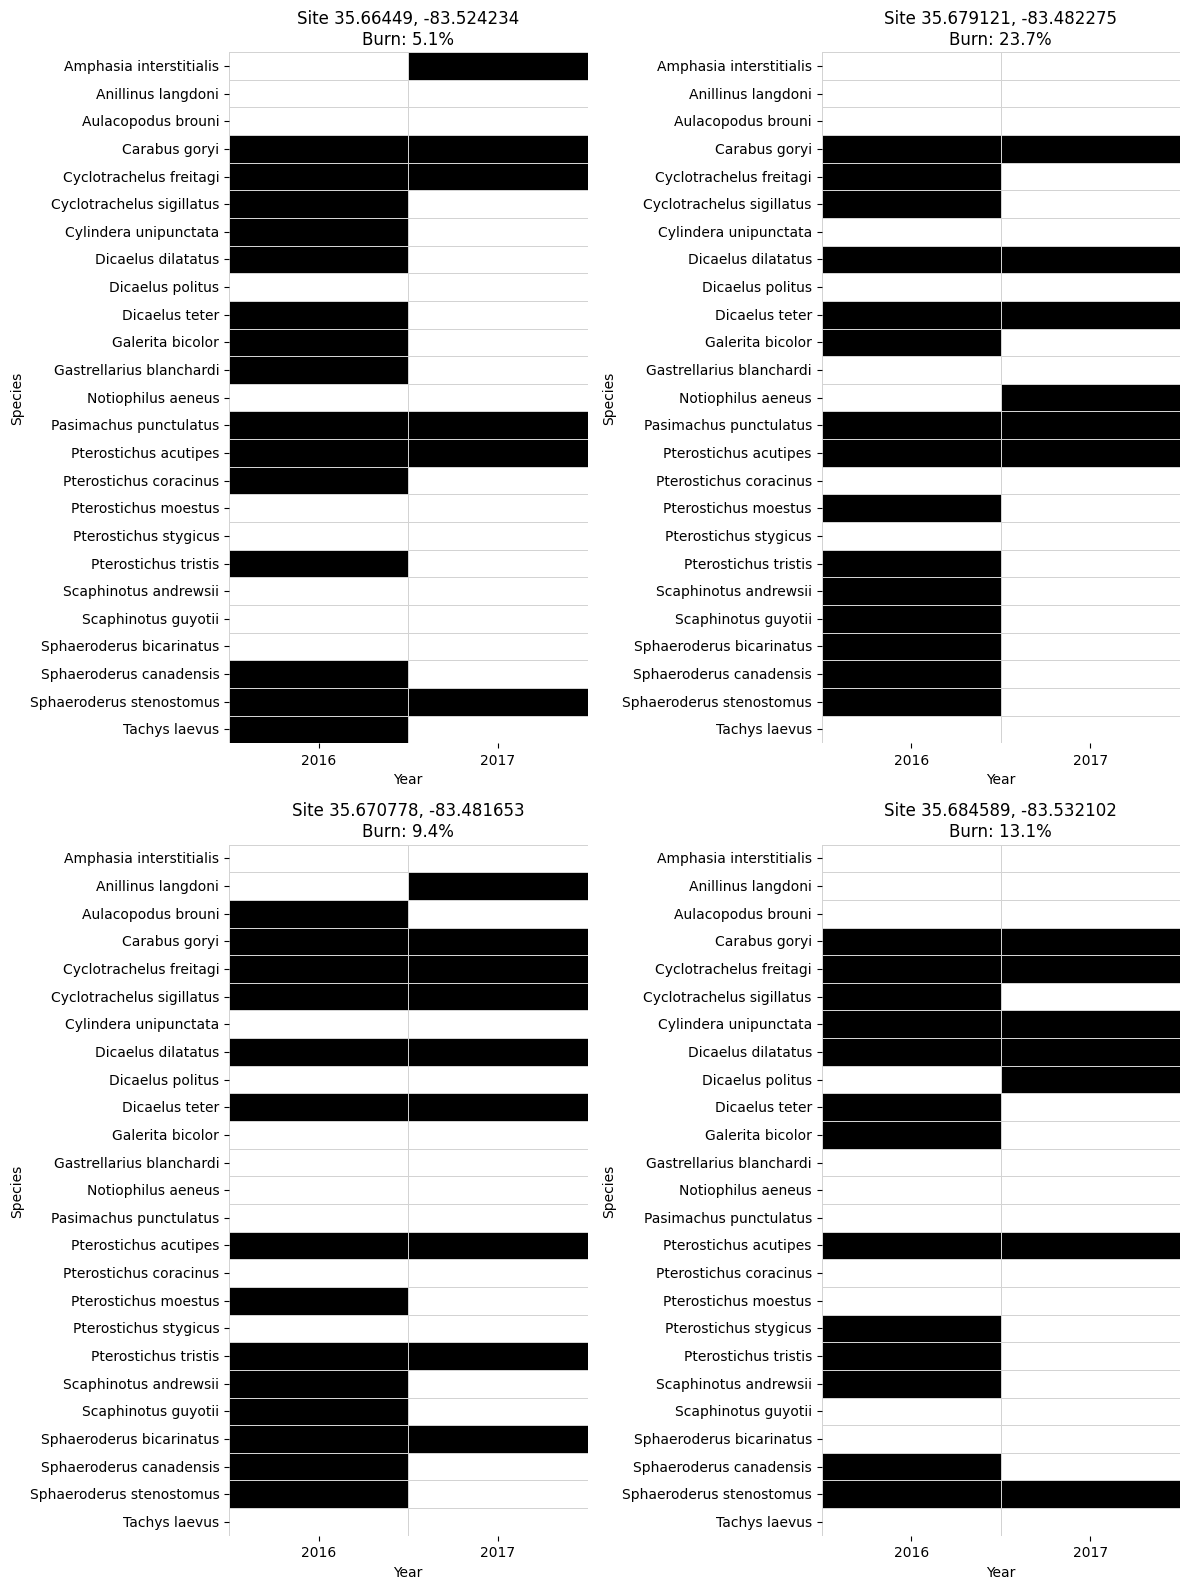

In [11]:
# ---------------------------------------
# 1) Load occurrences and tag each record with its trap `site`
# ---------------------------------------

occ_gdf = gpd.read_file("gbif_carabids_grsm_2016_2017.geojson")

occ_gdf['site'] = (
    occ_gdf['latitude'].round(6).astype(str) + ", " +
    occ_gdf['longitude'].round(6).astype(str)
)

all_species = sorted(occ_gdf['species'].unique())

# ---------------------------------------
# 2) Load burn‐percentage data & build a site → burn_pct lookup
# ---------------------------------------
df_burn = pd.read_csv("Trap_Burn_Percentage_Export.csv")
df_burn['geometry'] = df_burn['geometry'].apply(wkt.loads)
gdf_burn = gpd.GeoDataFrame(df_burn, geometry='geometry', crs="EPSG:4326")

# Compute centroids so we can recreate the same "site" key
gdf_burn['centroid'] = gdf_burn.geometry.centroid
gdf_burn['lat'] = gdf_burn.centroid.y.round(6)
gdf_burn['lon'] = gdf_burn.centroid.x.round(6)
gdf_burn['site'] = gdf_burn['lat'].astype(str) + ", " + gdf_burn['lon'].astype(str)

# Build a dict: site → burn percentage
burn_mapping = gdf_burn.set_index('site')['burn_pct'].to_dict()

# ---------------------------------------
# 3) Prepare subplots (2×2 for four sites)
# ---------------------------------------
sites = occ_gdf['site'].unique()
n_sites = len(sites)
n_cols = 2
n_rows = int(np.ceil(n_sites / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 8))

# ---------------------------------------
# 4) Loop over each site, build presence/absence, and plot
# ---------------------------------------
for ax, site in zip(axes.flat, sites):
    # Filter to that site
    occ_site = occ_gdf[occ_gdf['site'] == site]
    
    # One row per species-year
    presence = (
        occ_site[['species', 'year']]
        .drop_duplicates()
        .assign(presence=1)
    )
    
    # Pivot into species × year
    pivot = (
        presence
        .pivot(index='species', columns='year', values='presence')
        .fillna(0)
        .astype(int)
    )
    
    # Ensure both years are columns
    for yr in [2016, 2017]:
        if yr not in pivot.columns:
            pivot[yr] = 0
    pivot = pivot[[2016, 2017]]

    pivot = pivot.reindex(index=all_species, fill_value=0)
    
    # Plot heatmap
    sns.heatmap(
        pivot,
        cmap='Greys',
        cbar=False,
        linewidths=0.5,
        linecolor='lightgray',
        ax=ax
    )
    
    # Get burn percentage for this site
    burn_pct = burn_mapping.get(site, 0.0)
    
    # Update title to include site and burn %
    ax.set_title(f"Site {site}\nBurn: {burn_pct:.1f}%", fontsize=12)
    ax.set_xlabel("Year")
    ax.set_ylabel("Species")

# Turn off any extra axes (if fewer than 4 sites)
for ax in axes.flat[n_sites:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

### Questions - on your own:
- What are some trends you can find from looking at these four plots, broken out by burn percentage?
- Are there any species-specific findings you can determine or hypotheses you can make from these heatmaps?

### Recap

Congratulations! In this lesson you have learned how to work with GBIF and NEON AOP data together, using `geemap` and `pygbif`, and have gone through an example to assess impacts of a wildfire on beetle trap occurrence data.

**Author Contact**:

Kit Lewers
- Kristen.Lewers@colorado.edu
- https://github.com/kllewers